## 1. Setup e Importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score, balanced_accuracy_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import shap

warnings.filterwarnings('ignore')
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print('✓ Setup concluído')

✓ Setup concluído


## 2. ETL - Extração, Transformação e Carga

### 2.1 Funções de Carregamento

In [9]:
def carregar_dados_basicos(ano):
    """Carrega dados básicos do TSE (candidatos, complementar, bens)"""
    base = f'../data'
    
    cand = pd.read_csv(f'{base}/consulta_cand_{ano}/consulta_cand_{ano}_BRASIL.csv',
                       encoding='latin1', sep=';', low_memory=False)
    cand_comp = pd.read_csv(f'{base}/consulta_cand_complementar_{ano}/consulta_cand_complementar_{ano}_BRASIL.csv',
                            encoding='latin1', sep=';', low_memory=False)
    bens = pd.read_csv(f'{base}/bem_candidato_{ano}/bem_candidato_{ano}_BRASIL.csv',
                       encoding='latin1', sep=';', low_memory=False)
    
    # Filtrar Deputado Federal
    cand = cand[cand['CD_CARGO'] == 6].copy()
    
    # Merge
    df = cand.merge(cand_comp[['SQ_CANDIDATO', 'ST_REELEICAO', 'VR_DESPESA_MAX_CAMPANHA', 'NR_IDADE_DATA_POSSE']],
                    on='SQ_CANDIDATO', how='left')
    
    # Patrimônio
    bens['VR_BEM_CANDIDATO'] = bens['VR_BEM_CANDIDATO'].str.replace('"', '').str.replace(',', '.').astype(float)
    patrimonio = bens.groupby('SQ_CANDIDATO')['VR_BEM_CANDIDATO'].sum().reset_index()
    patrimonio.columns = ['SQ_CANDIDATO', 'TOTAL_BENS']
    df = df.merge(patrimonio, on='SQ_CANDIDATO', how='left')
    df['TOTAL_BENS'] = df['TOTAL_BENS'].fillna(0)
    
    return df

def carregar_dados_financeiros(ano):
    """Carrega dados de prestação de contas (receitas e despesas pagas)"""
    base = f'../data/prestacao_de_contas_eleitorais_candidatos_{ano}'
    
    # Receitas
    receitas = pd.read_csv(f'{base}/receitas_candidatos_{ano}_BRASIL.csv',
                           encoding='latin1', sep=';', low_memory=False)
    receitas['VR_RECEITA'] = pd.to_numeric(
        receitas['VR_RECEITA'].astype(str).str.replace('"', '').str.replace(',', '.'), errors='coerce')
    
    rec_agg = receitas.groupby('SQ_CANDIDATO').agg(
        TOTAL_RECEITAS=('VR_RECEITA', 'sum'),
        QTD_DOACOES=('VR_RECEITA', 'count')
    ).reset_index()
    
    # Despesas - JOIN entre contratadas (tem SQ_CANDIDATO) e pagas (tem VR_PAGTO_DESPESA)
    despesas_contratadas = pd.read_csv(f'{base}/despesas_contratadas_candidatos_{ano}_BRASIL.csv',
                                        encoding='latin1', sep=';', low_memory=False)
    despesas_pagas = pd.read_csv(f'{base}/despesas_pagas_candidatos_{ano}_BRASIL.csv',
                                  encoding='latin1', sep=';', low_memory=False)
    
    # Recuperar SQ_CANDIDATO via SQ_DESPESA
    despesas = despesas_pagas.merge(
        despesas_contratadas[['SQ_DESPESA', 'SQ_CANDIDATO']], 
        on='SQ_DESPESA', 
        how='left'
    )
    
    # Converter valores pagos
    despesas['VR_PAGTO_DESPESA'] = pd.to_numeric(
        despesas['VR_PAGTO_DESPESA'].astype(str).str.replace('"', '').str.replace(',', '.'), errors='coerce')
    
    desp_agg = despesas.groupby('SQ_CANDIDATO').agg(
        TOTAL_DESPESAS=('VR_PAGTO_DESPESA', 'sum'),
        QTD_DESPESAS=('VR_PAGTO_DESPESA', 'count')
    ).reset_index()
    
    return rec_agg, desp_agg

print('✓ Funções definidas')

✓ Funções definidas


### 2.2 Carregamento de Dados

In [10]:
print('Carregando dados...')

# 2018 (Treino)
df_2018 = carregar_dados_basicos(2018)
rec_2018, desp_2018 = carregar_dados_financeiros(2018)
df_2018 = df_2018.merge(rec_2018, on='SQ_CANDIDATO', how='left')
df_2018 = df_2018.merge(desp_2018, on='SQ_CANDIDATO', how='left')
df_2018['ANO'] = 2018

# 2022 (Teste)
df_2022 = carregar_dados_basicos(2022)
rec_2022, desp_2022 = carregar_dados_financeiros(2022)
df_2022 = df_2022.merge(rec_2022, on='SQ_CANDIDATO', how='left')
df_2022 = df_2022.merge(desp_2022, on='SQ_CANDIDATO', how='left')
df_2022['ANO'] = 2022

print(f'2018: {len(df_2018):,} candidatos | 2022: {len(df_2022):,} candidatos')

Carregando dados...
2018: 8,607 candidatos | 2022: 10,630 candidatos


### 2.3 Definição do Target e Limpeza

In [11]:
def preparar_dataset(df):
    """Limpa dados e define target"""
    df = df.copy()
    
    # Target
    eleito_status = ['ELEITO', 'ELEITO POR MÉDIA', 'ELEITO POR QP']
    df['ELEITO'] = df['DS_SIT_TOT_TURNO'].isin(eleito_status).astype(int)
    
    # Filtrar apenas com resultado definido
    df = df[df['DS_SIT_TOT_TURNO'].notna()]
    
    # Limpar #NULO e #NE
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].replace(['#NULO', '#NE', '"#NULO"', '"#NE"'], np.nan)
    
    # Tratar VR_DESPESA_MAX_CAMPANHA
    df['VR_DESPESA_MAX_CAMPANHA'] = pd.to_numeric(
        df['VR_DESPESA_MAX_CAMPANHA'].astype(str).str.replace('"', '').str.replace(',', '.'), errors='coerce')
    
    # Preencher missings
    df['ST_REELEICAO'] = df['ST_REELEICAO'].fillna('N')
    df['VR_DESPESA_MAX_CAMPANHA'] = df['VR_DESPESA_MAX_CAMPANHA'].fillna(0)
    df['NR_IDADE_DATA_POSSE'] = df['NR_IDADE_DATA_POSSE'].fillna(df['NR_IDADE_DATA_POSSE'].median())
    df['TOTAL_RECEITAS'] = df['TOTAL_RECEITAS'].fillna(0)
    df['TOTAL_DESPESAS'] = df['TOTAL_DESPESAS'].fillna(0)
    df['QTD_DOACOES'] = df['QTD_DOACOES'].fillna(0)
    df['QTD_DESPESAS'] = df['QTD_DESPESAS'].fillna(0)
    
    # Remover críticos ausentes
    df = df.dropna(subset=['CD_GENERO', 'CD_GRAU_INSTRUCAO', 'SG_PARTIDO'])
    
    return df

df_2018 = preparar_dataset(df_2018)
df_2022 = preparar_dataset(df_2022)

print(f'Após limpeza - 2018: {len(df_2018):,} | 2022: {len(df_2022):,}')
print(f'Taxa eleitos 2018: {df_2018["ELEITO"].mean()*100:.2f}% | 2022: {df_2022["ELEITO"].mean()*100:.2f}%')

Após limpeza - 2018: 8,607 | 2022: 10,630
Taxa eleitos 2018: 5.96% | 2022: 4.83%


## 3. EDA - Análise Exploratória

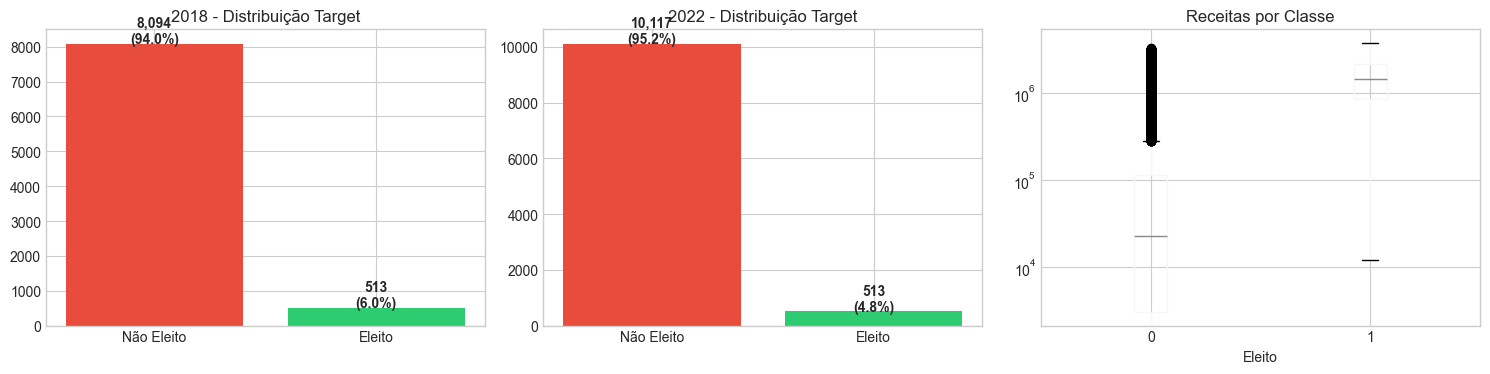

Desbalanceamento geral: 1:17.7


In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Desbalanceamento
for i, (df, ano) in enumerate([(df_2018, 2018), (df_2022, 2022)]):
    counts = df['ELEITO'].value_counts()
    axes[i].bar(['Não Eleito', 'Eleito'], counts.values, color=['#e74c3c', '#2ecc71'])
    axes[i].set_title(f'{ano} - Distribuição Target')
    for j, v in enumerate(counts.values):
        axes[i].text(j, v + 20, f'{v:,}\n({v/len(df)*100:.1f}%)', ha='center', fontweight='bold')

# Receitas por classe
df_combined = pd.concat([df_2018, df_2022])
df_combined.boxplot(column='TOTAL_RECEITAS', by='ELEITO', ax=axes[2])
axes[2].set_title('Receitas por Classe')
axes[2].set_xlabel('Eleito')
axes[2].set_yscale('log')
plt.suptitle('')

plt.tight_layout()
plt.show()

ratio = (1 - df_combined['ELEITO'].mean()) / df_combined['ELEITO'].mean()
print(f'Desbalanceamento geral: 1:{ratio:.1f}')

In [13]:
# Estatísticas financeiras por classe
stats = df_combined.groupby('ELEITO').agg({
    'TOTAL_RECEITAS': ['mean', 'median'],
    'TOTAL_DESPESAS': ['mean', 'median'],
    'TOTAL_BENS': ['mean', 'median']
}).round(2)

print('Estatísticas Financeiras por Classe:')
print(stats)
print(f'\nRatio Receita (Eleito/Não Eleito): {df_combined[df_combined["ELEITO"]==1]["TOTAL_RECEITAS"].mean() / df_combined[df_combined["ELEITO"]==0]["TOTAL_RECEITAS"].mean():.1f}x')

Estatísticas Financeiras por Classe:
       TOTAL_RECEITAS             TOTAL_DESPESAS              TOTAL_BENS  \
                 mean      median           mean      median        mean   
ELEITO                                                                     
0           168188.83    22350.00      334702.84    21310.00   787680.51   
1          1509228.48  1444589.14     3952698.08  2887874.47  2586171.32   

                  
          median  
ELEITO            
0        40000.0  
1       957973.1  

Ratio Receita (Eleito/Não Eleito): 9.0x


## 4. Feature Engineering

In [14]:
def criar_features(df, partido_enc=None, ocupacao_enc=None, fit=False):
    """Cria todas as features para modelagem"""
    df = df.copy()
    
    # Features básicas
    df['IS_REELEICAO'] = (df['ST_REELEICAO'] == 'S').astype(int)
    df['IS_FEMININO'] = (df['CD_GENERO'] == 4).astype(int)
    df['TEM_BENS'] = (df['TOTAL_BENS'] > 0).astype(int)
    df['IDADE'] = df['NR_IDADE_DATA_POSSE']
    
    # Features financeiras (LOG para normalizar)
    df['LOG_RECEITAS'] = np.log1p(df['TOTAL_RECEITAS'])
    df['LOG_DESPESAS'] = np.log1p(df['TOTAL_DESPESAS'])
    df['LOG_BENS'] = np.log1p(df['TOTAL_BENS'])
    df['LOG_DESPESA_MAX'] = np.log1p(df['VR_DESPESA_MAX_CAMPANHA'])
    
    # Features derivadas
    df['SALDO_CAMPANHA'] = df['TOTAL_RECEITAS'] - df['TOTAL_DESPESAS']
    df['TAXA_EXECUCAO'] = np.where(df['TOTAL_RECEITAS'] > 0, 
                                    df['TOTAL_DESPESAS'] / df['TOTAL_RECEITAS'], 0)
    df['RECEITA_POR_DOACAO'] = np.where(df['QTD_DOACOES'] > 0,
                                         df['TOTAL_RECEITAS'] / df['QTD_DOACOES'], 0)
    
    # Target Encoding
    if fit:
        partido_enc = df.groupby('SG_PARTIDO')['ELEITO'].mean()
        ocupacao_enc = df.groupby('CD_OCUPACAO')['ELEITO'].mean()
    
    df['PARTIDO_ENC'] = df['SG_PARTIDO'].map(partido_enc).fillna(partido_enc.mean())
    df['OCUPACAO_ENC'] = df['CD_OCUPACAO'].map(ocupacao_enc).fillna(ocupacao_enc.mean())
    
    # One-hot UF
    uf_dummies = pd.get_dummies(df['SG_UF'], prefix='UF', drop_first=True)
    
    # Features finais
    features = [
        'IDADE', 'IS_FEMININO', 'IS_REELEICAO', 'TEM_BENS',
        'CD_GRAU_INSTRUCAO', 'CD_COR_RACA',
        'LOG_RECEITAS', 'LOG_DESPESAS', 'LOG_BENS', 'LOG_DESPESA_MAX',
        'SALDO_CAMPANHA', 'TAXA_EXECUCAO', 'RECEITA_POR_DOACAO', 'QTD_DOACOES',
        'PARTIDO_ENC', 'OCUPACAO_ENC'
    ]
    
    X = pd.concat([df[features], uf_dummies], axis=1)
    y = df['ELEITO']
    
    if fit:
        return X, y, partido_enc, ocupacao_enc, uf_dummies.columns.tolist()
    return X, y

# Criar features com encoding do treino
X_train, y_train, partido_enc, ocupacao_enc, uf_cols = criar_features(df_2018, fit=True)
X_test, y_test = criar_features(df_2022, partido_enc, ocupacao_enc)

# Alinhar colunas
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0
X_test = X_test[X_train.columns]

# Tratar NaN
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

print(f'Features: {X_train.shape[1]} | Treino: {len(X_train):,} | Teste: {len(X_test):,}')

Features: 42 | Treino: 8,607 | Teste: 10,630


## 5. Preparação para Modelagem

In [15]:
# Padronização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_dict = {0: class_weights[0], 1: class_weights[1]}
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f'Padronização: μ={X_train_scaled.mean():.4f}, σ={X_train_scaled.std():.4f}')
print(f'Class weights: 0={class_weights[0]:.3f}, 1={class_weights[1]:.3f}')
print(f'scale_pos_weight: {scale_pos_weight:.2f}')

Padronização: μ=0.0000, σ=0.9880
Class weights: 0=0.532, 1=8.389
scale_pos_weight: 15.78


## 6. Treinamento dos Modelos

In [16]:
def avaliar(y_true, y_pred, y_proba):
    """Retorna métricas de avaliação"""
    return {
        'F1': f1_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_proba),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Balanced_Acc': balanced_accuracy_score(y_true, y_pred)
    }

resultados = {}

In [17]:
# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
lr_proba = lr.predict_proba(X_test_scaled)[:, 1]
resultados['Logistic Regression'] = avaliar(y_test, lr_pred, lr_proba)
print(f"LR: F1={resultados['Logistic Regression']['F1']:.4f} | AUC={resultados['Logistic Regression']['AUC']:.4f}")

LR: F1=0.3190 | AUC=0.9711


In [18]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=15, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)
rf_proba = rf.predict_proba(X_test_scaled)[:, 1]
resultados['Random Forest'] = avaliar(y_test, rf_pred, rf_proba)
print(f"RF: F1={resultados['Random Forest']['F1']:.4f} | AUC={resultados['Random Forest']['AUC']:.4f}")

RF: F1=0.5170 | AUC=0.9548


In [19]:
# Gradient Boosting
sample_weights = np.where(y_train == 1, class_weights[1], class_weights[0])
gb = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
gb.fit(X_train_scaled, y_train, sample_weight=sample_weights)
gb_pred = gb.predict(X_test_scaled)
gb_proba = gb.predict_proba(X_test_scaled)[:, 1]
resultados['Gradient Boosting'] = avaliar(y_test, gb_pred, gb_proba)
print(f"GB: F1={resultados['Gradient Boosting']['F1']:.4f} | AUC={resultados['Gradient Boosting']['AUC']:.4f}")

GB: F1=0.4211 | AUC=0.8994


In [20]:
# XGBoost com GridSearch
print('XGBoost GridSearch (pode levar alguns minutos)...')

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1]
}

xgb_base = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss', n_jobs=-1)
grid = GridSearchCV(xgb_base, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

xgb_model = grid.best_estimator_
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
resultados['XGBoost'] = avaliar(y_test, xgb_pred, xgb_proba)

print(f"XGB: F1={resultados['XGBoost']['F1']:.4f} | AUC={resultados['XGBoost']['AUC']:.4f}")
print(f"Melhores params: {grid.best_params_}")

XGBoost GridSearch (pode levar alguns minutos)...
XGB: F1=0.5124 | AUC=0.9543
Melhores params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


## 7. Avaliação Comparativa

In [21]:
# Tabela de resultados
results_df = pd.DataFrame(resultados).T.round(4)
results_df = results_df.sort_values('F1', ascending=False)
print('='*60)
print('RESULTADOS - Validação Temporal (2018 → 2022)')
print('='*60)
print(results_df)
print('='*60)
print(f'\n🏆 Melhor modelo: {results_df.index[0]} (F1={results_df.iloc[0]["F1"]:.4f})')

RESULTADOS - Validação Temporal (2018 → 2022)
                         F1     AUC  Precision  Recall  Balanced_Acc
Random Forest        0.5170  0.9548     0.3965  0.7427        0.8427
XGBoost              0.5124  0.9543     0.3721  0.8226        0.8761
Gradient Boosting    0.4211  0.8994     0.3037  0.6862        0.8032
Logistic Regression  0.3190  0.9711     0.1904  0.9844        0.8860

🏆 Melhor modelo: Random Forest (F1=0.5170)


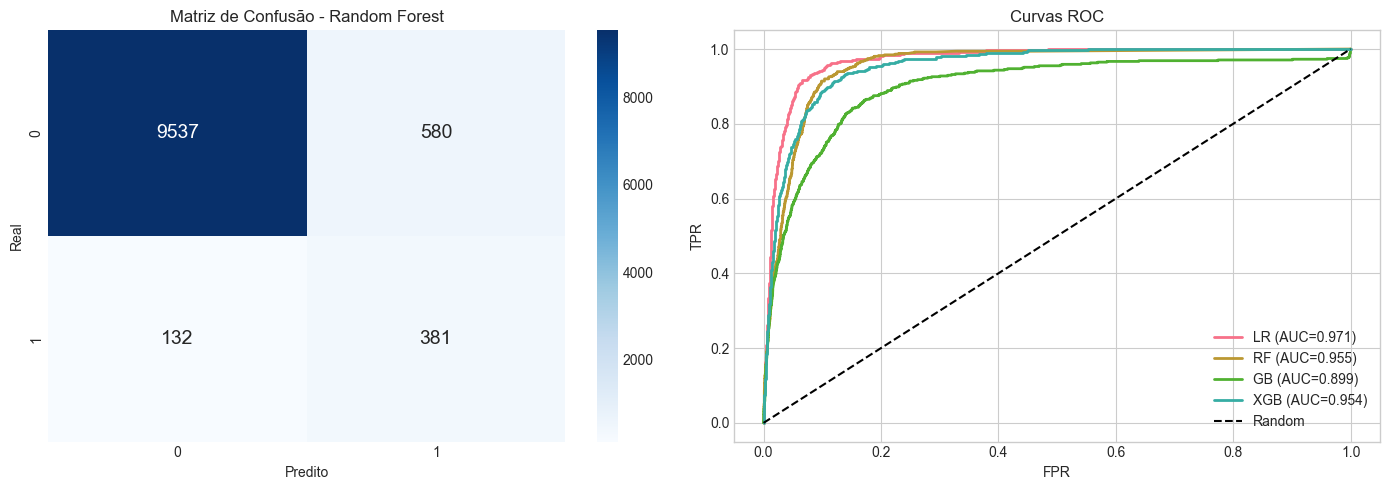

In [22]:
# Visualizações
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matrizes de Confusão (melhor modelo)
best_pred = xgb_pred if results_df.index[0] == 'XGBoost' else (lr_pred if results_df.index[0] == 'Logistic Regression' else (rf_pred if results_df.index[0] == 'Random Forest' else gb_pred))
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], annot_kws={'size': 14})
axes[0].set_title(f'Matriz de Confusão - {results_df.index[0]}')
axes[0].set_xlabel('Predito')
axes[0].set_ylabel('Real')

# Curvas ROC
for name, proba in [('LR', lr_proba), ('RF', rf_proba), ('GB', gb_proba), ('XGB', xgb_proba)]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    axes[1].plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test, proba):.3f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('FPR')
axes[1].set_ylabel('TPR')
axes[1].set_title('Curvas ROC')
axes[1].legend()

plt.tight_layout()
plt.show()

## 8. Explicabilidade - SHAP

Calculando SHAP values...


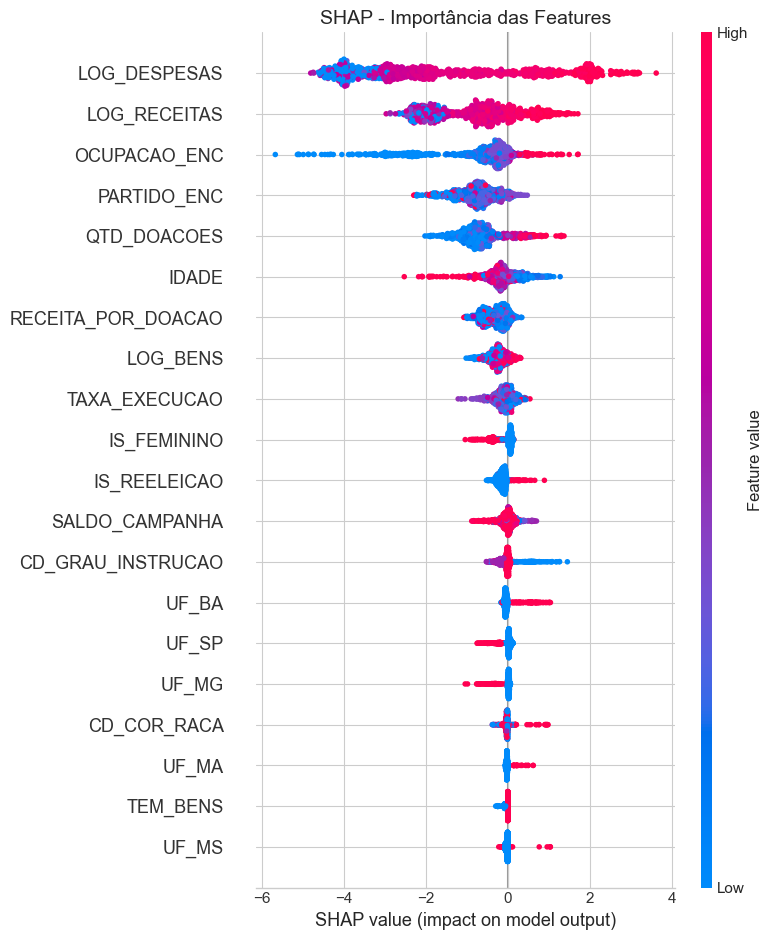

In [23]:
print('Calculando SHAP values...')
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_scaled[:1000])

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_scaled[:1000], feature_names=X_train.columns, show=False)
plt.title('SHAP - Importância das Features', fontsize=14)
plt.tight_layout()
plt.show()

In [24]:
# Top 10 Features
shap_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(shap_values).mean(axis=0)
}).sort_values('Importance', ascending=False).head(10)

print('Top 10 Features (SHAP):')
for i, row in shap_importance.iterrows():
    print(f"  {row['Feature']:25s}: {row['Importance']:.4f}")

Top 10 Features (SHAP):
  LOG_DESPESAS             : 2.4138
  LOG_RECEITAS             : 1.0622
  OCUPACAO_ENC             : 0.8772
  PARTIDO_ENC              : 0.7514
  QTD_DOACOES              : 0.7298
  IDADE                    : 0.3370
  RECEITA_POR_DOACAO       : 0.3254
  LOG_BENS                 : 0.2565
  TAXA_EXECUCAO            : 0.1771
  IS_FEMININO              : 0.1648


## 9. Análise por UF

In [25]:
df_2022_pred = df_2022.copy()
df_2022_pred['PROB_ELEICAO'] = xgb_proba

uf_analysis = df_2022_pred.groupby('SG_UF').agg({
    'ELEITO': ['sum', 'count', 'mean'],
    'PROB_ELEICAO': 'mean'
}).round(4)
uf_analysis.columns = ['Eleitos', 'Total', 'Taxa_Real', 'Prob_Media']
uf_analysis = uf_analysis.sort_values('Taxa_Real', ascending=False)

print('Top 10 UFs por Taxa de Eleição:')
print(uf_analysis.head(10))

Top 10 UFs por Taxa de Eleição:
       Eleitos  Total  Taxa_Real  Prob_Media
SG_UF                                       
AC           8    140     0.0571      0.1534
RS          31    546     0.0568      0.1049
PI          10    177     0.0565      0.1364
CE          22    414     0.0531      0.1153
PE          25    474     0.0527      0.1036
PA          17    323     0.0526      0.1615
AP           8    154     0.0519      0.1637
SC          16    314     0.0510      0.1237
BA          39    776     0.0503      0.1093
ES          10    201     0.0498      0.1376


## 10. Conclusões

In [ ]:
print('='*70)
print('CONCLUSÕES DO PROJETO')
print('='*70)

best_model = results_df.index[0]
best_f1 = results_df.iloc[0]['F1']
best_auc = results_df.iloc[0]['AUC']

print(f'''
🏆 MODELO VENCEDOR: {best_model}
   F1-Score: {best_f1:.4f}
   AUC-ROC:  {best_auc:.4f}

📊 VALIDAÇÃO TEMPORAL:
   Treino: 2018 ({len(df_2018):,} candidatos)
   Teste:  2022 ({len(df_2022):,} candidatos)

🔑 TOP 5 FEATURES MAIS IMPORTANTES:
''')
for i, row in shap_importance.head(5).iterrows():
    print(f"   {i+1}. {row['Feature']}")

print('''
💡 INSIGHTS:
   - Dados financeiros (receitas/despesas) são altamente preditivos
   - Reeleição continua sendo fator importante
   - Modelo generaliza bem entre ciclos eleitorais

⚠️  LIMITAÇÕES:
   - Dados financeiros só disponíveis pós-eleição
   - Contexto político varia entre eleições
   - Performance limitada pelo desbalanceamento severo
''')
print('='*70)

CONCLUSÕES DO PROJETO

🏆 MODELO VENCEDOR: Random Forest
   F1-Score: 0.5170
   AUC-ROC:  0.9548

📊 VALIDAÇÃO TEMPORAL:
   Treino: 2018 (8,607 candidatos)
   Teste:  2022 (10,630 candidatos)

🔑 TOP 5 FEATURES MAIS IMPORTANTES:

   8. LOG_DESPESAS
   7. LOG_RECEITAS
   16. OCUPACAO_ENC
   15. PARTIDO_ENC
   14. QTD_DOACOES

💡 INSIGHTS:
   - Dados financeiros (receitas/despesas) são altamente preditivos
   - Reeleição continua sendo fator importante
   - Modelo generaliza bem entre ciclos eleitorais

⚠️  LIMITAÇÕES:
   - Dados financeiros só disponíveis pós-eleição
   - Contexto político varia entre eleições
   - Performance limitada pelo desbalanceamento severo

